## Assignment 3 Question 2

Is it possible to predict ELO of a player based on context of a potential en passant move?

Only investigating the player who is in the position of making the en passant move.

Lila See FDS PCA solutions for 3 good points for what PCA is good for - include in report?

#### Import Libraries

In [1]:
import pandas as pd
import chess
import chess.pgn
import chess.engine
import io
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time

from pandarallel import pandarallel

import data_cleaning

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

#### Import stockfish 🐟🐟🐟

In [2]:
# Windows installation
STOCKFISH_LOC = os.getcwd() + "\stockfish\stockfish-windows-2022-x86-64-avx2.exe"
# Unix based installation i.e. DICE/Codespaces
STOCKFISH_LOC_UNIX = os.getcwd() + "/stockfish_14_linux/stockfish_14_x64"

# Import stockfish package
from stockfish import Stockfish
# Try and read windows location
try:
    fish = Stockfish(path=STOCKFISH_LOC, depth=10, parameters={"Threads": 2, "Hash": 32})
    
# If error, read the linux location
except:
    fish = Stockfish(path=STOCKFISH_LOC_UNIX, depth=10, parameters={"Threads": 2, "Hash": 32})
    
# It will throw an error but if it still runs then ignore it :D

Exception ignored in: <function Stockfish.__del__ at 0x7f0da96a4e50>
Traceback (most recent call last):
  File "/afs/inf.ed.ac.uk/user/s22/s2202694/.local/lib/python3.8/site-packages/stockfish/models.py", line 757, in __del__
    if self._stockfish.poll() is None:
AttributeError: 'Stockfish' object has no attribute '_stockfish'


#### Import CSV file

66879 entries in dataframe

In [3]:
chess_data = data_cleaning.import_data()
print(chess_data.dtypes)

white_username    object
black_username    object
white_id          object
black_id          object
white_rating       int64
black_rating       int64
white_result      object
black_result      object
time_class        object
time_control      object
rules             object
rated               bool
fen               object
pgn               object
dtype: object


#### Dataframe info

Using:
print(chess_data.dtypes)
print(chess["rules"].unique())


Chess rules:
['chess' 'chess960' 'threecheck' 'crazyhouse' 'kingofthehill']

Time control:
['1/259200' '1/172800' '1800' '1/86400' '1/432000' '1/604800' '600'
 '120+1' '900+10' '300' '180+2' '3600+5' '2700+45' '3600' '1/1209600'
 '180' '600+10' '60' '480+3' '300+5' '420+3' '600+5' '600+2' '1200' '30'
 '60+1' '120' '1500+3' '900+2' '1500+5' '1500+10' '1/864000' '900' '300+2'
 '1500' '7200' '300+1' '5400' '3600+60' '2700+30' '3480+45' '10' '2700+10'
 '15' '2700' '3600+20' '4500' '4200' '900+5' '1800+10' '2700+5' '480+5'
 '1800+30' '300+3' '600+1' '1800+5' '420+5' '5400+30' '240+10' '420' '303'
 '60+10']

 Time class:
['daily' 'rapid' 'bullet' 'blitz']

#### Clean data

Undeveloped board shouldn't matter if we're filtering games for potential ep

Same for draws

Can filter our time class if are looking at time controls

After making a new move_list column, should we drop the pgn column?


Variables we are considering when predicting ELO (for a player who could potentially make en passant move) are: (Y = DONE, N = NOT DONE)
- Y: Colour who had ep opportunity (boolean)
- Y: Did they take the en passant? (boolean)
- N: Does their choice on taking/not taking support them if gaining an advantage? (numerical value for how much of an advantage it gives)
- N: Time taken to decide to capture/not capture en passant (... whatever can be time, a number in seconds ig)
- Y: Is the game rated? (boolean)
- Y: Game time class


To do:
- Work out which colour is making the potential en passant move, add a column to dataframe detailing this
- Make dataframe columns for other variables
- Apply PCA reduction

In [4]:
# Save PGN column from dataframe
full_pgn = chess_data['pgn']

def get_moves(entry):
    '''
    Retrive series of moves in a game when given the whole full_pgn entry
    '''
    pgn = entry.splitlines()[-1]
    return pgn

# Add list of moves (string) as a new column to dataframe
chess_data['move_list'] = full_pgn.apply(get_moves)
# Drop irrelevant columns
chess_data = chess_data.drop(['white_username', 'black_username','white_id', 'black_id', 'white_result', 'black_result', 'rules'], axis=1)

### Processing data and adding information

#### Checks every game for ones that have potential en-passant moves
- Gets whether a game has an en-passant opportunity
- Gets whether the said en passant move was played
- Gets the colour of the player that has the e.p. opportunity

In [5]:
def check_pgn(df_row):
    import io
    import chess
    import chess.pgn
    
    '''
    Checks PGN for whether opportunity for EP happened in the game.
    '''
    
    pgn_file = io.StringIO(df_row["pgn"])   # PGN as a file
    game = chess.pgn.read_game(pgn_file)    # Read PGN and put into game
    board = game.board()                    # "board" of a game
    # pre-initialise df_row values
    precheck = False
    moved = False
    move_colour = ""

    # comparison sets when checking move piece
    ep_set = set(["ax","bx","cx","dx","ex","fx","gx", "hx"])
    check_set = set("abcdefgh")
    
    # Find only pawn moves in game
    for board_move in game.mainline():
        move = board_move.move
        san = board.san(move)
        turn = board.turn
        move_piece = san[0]
        # check if precheck was flagged in previous move
        if precheck:
            # print(board_move.clock())
            # get first 2 letters, and compare to a set
            move_ep_piece = san[:2]
            if move_ep_piece in ep_set:
                # check if e.p. actually happened
                moved = board.is_en_passant(move)
            # break out for loop, no need to check further
            break
        
        # if the move was a pawn (lower case)
        if move_piece in check_set:
            # Push the move before checking the board
            board.push(move)
            # check if the next move can be en passant
            precheck = board.has_legal_en_passant()
            # if precheck is true then set the turn
            if precheck:
                if turn:
                    move_colour = 'Black'
                else:
                    move_colour = 'White'
        # if the move wasn't a pawn then just continue as normal
        else:
            board.push(move)
    
    # set row values
    df_row["ep_opportunity"] = precheck
    df_row["ep_happened"] = moved
    df_row["ep_colour"] = move_colour
    return df_row

chess_filter = chess_data.copy(deep=True)
# chess_filter = chess_data[chess_data["time_class"] != "daily"].sample(100).copy(deep=True)
chess_filter = chess_filter
pandarallel.initialize()

start = time.time()
# apply e.p. finding function
try:
    chess_filter = chess_filter.parallel_apply(check_pgn, axis=1)
except:
    chess_filter = chess_filter.apply(check_pgn, axis=1)
end = time.time()
print(end - start)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
132.36754488945007


#### Filter out games that don't have en-passant opportunity

In [6]:
chess_filter = chess_filter[chess_filter['ep_opportunity'] == True]
chess_filter = chess_filter.drop(['ep_opportunity'], axis=1)
chess_filter = chess_filter.reset_index(drop=True)
print(len(chess_filter))
print(len(chess_filter[chess_filter['ep_happened'] == True]))
# print(chess_filter["move_list"].sample(50).head(20))

5074
1563


#### Get the time taken to respond to an en-passant pawn move

In [7]:

def check_times(df_row):
    import io
    import chess
    import chess.pgn
    
    '''
    Checks PGN for whether opportunity for EP happened in the game.
    '''
    # print(df_row["move_list"])
    pgn_file = io.StringIO(df_row["pgn"])   # PGN as a file
    game = chess.pgn.read_game(pgn_file)    # Read PGN and put into game
    board = game.board()                    # "board" of a game
    # pre-initialise df_row values
    precheck = False

    # comparison sets when checking move piece
    check_set = set("abcdefgh")
    
    rolling_white_time = [0,0]
    rolling_black_time = [0,0]
    
    # Find only pawn moves in game
    for board_move in game.mainline():
        # print(board_move.clock())
        if board.turn:
            rolling_white_time = [board_move.clock(), rolling_white_time[0]]
            # print(rolling_white_time)
        else:
            rolling_black_time = [board_move.clock(), rolling_black_time[0]]
            # print(rolling_black_time)
        
        move = board_move.move
        san = board.san(move)
        move_piece = san[0]
        # check if precheck was flagged in previous move
        if precheck:
            # print(board_move.clock())
            # get first 2 letters, and compare to a set
            norm = df_row["time_control"]

            if board.turn:
                df_row["time_taken"] = (rolling_white_time[1] - rolling_white_time[0])/float(norm)
            else:
                df_row["time_taken"] = (rolling_black_time[1] - rolling_black_time[0])/float(norm)
            # print(df_row)
            return df_row
        
        # if the move was a pawn (lower case)
        # print(move_piece)
        if move_piece in check_set:
            # Push the move before checking the board
            board.push(move)
            # check if the next move can be en passant
            precheck = board.has_legal_en_passant()
            # print(precheck)
            # if precheck is true then set the turn
        # if the move wasn't a pawn then just continue as normal
        else:
            board.push(move)
    return df_row

pandarallel.initialize()

start = time.time()
# apply e.p. finding function
try:
    chess_filter = chess_filter.parallel_apply(check_times, axis=1)
except:
    chess_filter = chess_filter.apply(check_times, axis=1)
end = time.time()
print(end - start)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
9.634709358215332


#### Stockfish Evaluation to get evaluations of board choices
- Gets the evaluation before an ep opportunity
- Gets the evaluation of the best move calculated by Stockfish
- Gets the evaluation of the (best) en passant move calculated by Stockfish

In [8]:
def increment_letter(letter):
    '''increments a letter, returns "y" if on the "H" file'''
    if letter == "h":
        return "z"
    return chr(ord(letter) + 1)

def decrement_letter(letter):
    '''decrements a letter, returns "z" if on the "A" file'''
    if letter == "a":
        return "y"
    return chr(ord(letter) - 1)

def check_adjacent_piece(square, pawn):
    '''Checks if a piece on a square is an opponent pawn'''
    piece = fish.get_what_is_on_square(square)
    return True if piece == pawn else False

def get_abs_advantage(post, pre, col):
    '''
    Gets the absolute difference of an evaluation
    Need to factor for black side since centipawns is always from White POV
    '''

    difference = post - pre
    if col=="White":
        return difference
    else:
        return difference * -1
        

def get_best_move_evaluation(pre_eval, col):
    '''
    Gets the stockfish evaluation for the best move from a set state
    Returns a tuple of the evaluation, and whether e.p. was the best movee.
    '''

    best_move = fish.get_best_move()
    
    # if the best move is en-passant
    ep_best = False
    if fish.will_move_be_a_capture(best_move) == fish.Capture.EN_PASSANT:
        ep_best = True
    
    # play best move and measure evaluation
    fish.make_moves_from_current_position([best_move])
    post_eval = fish.get_evaluation()
    
    # get difference of best move against the previous evaluation
    post_eval_best_diff = get_abs_advantage(post_eval["value"], pre_eval["value"], col)

    return [post_eval_best_diff, ep_best]

def get_adj_squares(board, col, last_move):
    '''
    Returns a tuple of the left and right adjacent squares to a move
    '''

    # resulting column in the form "a - g"
    pawn_move_col = last_move[-2]
    # resulting row in the form "1 - 8"
    pawn_move_row = last_move[-1]

    # concatenate strings to make a square
    left_sq = decrement_letter(pawn_move_col) + pawn_move_row
    right_sq = increment_letter(pawn_move_col) + pawn_move_row
    return [left_sq, right_sq]
    
def check_valid_pawn(board, col, bounds, squares):
    '''
    Checks whether the left or right adjacent squares to a pawn
    is a valid en-passant move
    Returns validity of left square, right square as booleans
    '''

    # unpack tuples
    left_bound, right_bound = bounds
    left_square, right_square = squares
    
    # if colour is white, we are looking for a white pawn
    if col == "White":
        FISH_PAWN = fish.Piece.WHITE_PAWN
    # if colour is black, we are looking for a black pawn
    else:
        FISH_PAWN = fish.Piece.BLACK_PAWN

    # reset the fen of stockfish
    fish.set_fen_position(board.fen())

    # if corresponding square is a pawn of correct colour
    valid_left = False
    valid_right = False

    # if somewhere in the middle then check both sides
    if (not left_bound) and (not right_bound):
        valid_left = check_adjacent_piece(left_square, FISH_PAWN)
        valid_right = check_adjacent_piece(right_square, FISH_PAWN)
    
    # if pawn is on A file (leftmost)
    elif left_bound:
        # check right only
        valid_right = check_adjacent_piece(right_square, FISH_PAWN)
    
    # if pawn is on H file (rightmost)
    elif right_bound:
        # check left only
        valid_left = check_adjacent_piece(left_square, FISH_PAWN)
    
    return valid_left, valid_right

def ep_eval(fen, move, col):
    '''
    Make a move and get the evaluation after making said move
    '''

    # reset board to pre-move FEN
    fish.set_fen_position(fen)
    # make the move on stockfish
    fish.make_moves_from_current_position([move])
    
    val = fish.get_evaluation()["value"]
    return val


def stockfish_analyse_board(df_row, board):
    '''
    Gets a stockfish evaluation of the best move played,
    and also the evaluation if e.p. is played
    Returns a triple of pre-move evaluation, evaluation difference of best
    move, evaluation difference of (best) en passant move
    '''

    col = df_row["ep_colour"]
    
    # reset fen
    fish.set_fen_position(board.fen())
    
    # get pre-move evaluation
    pre_eval = fish.get_evaluation()

    # use stockfish to get the best move, and the resulting evaluation
    post_eval_best_diff, ep_best = get_best_move_evaluation(pre_eval, col)
    
    # if the best move is e.p. then return immediately
    if ep_best:
        return [pre_eval, post_eval_best_diff, post_eval_best_diff]
    
    # e.g. "e7e5"
    last_move = str(board.peek())
    
    # get adjacent squares of the pre-e.p. move
    squares = get_adj_squares(board, col, last_move)
    left_square, right_square = squares

    # checks the move is in leftmost or rightmost column
    left_bound = True if left_square[-2] == "y" else False
    right_bound = True if right_square[-2] == "z" else False
    bounds = [left_bound, right_bound]

    ep_left, ep_right = check_valid_pawn(board, col, bounds, squares)
    
    # if white is attacking then e.p. on row 6
    # if black is attacking then e.p. on row 3
    resulting_row = "6" if col == "White" else "3"
    
    # init values
    eval_ep_left = 0
    eval_ep_right = 0
    
    # if en passant can be played from both the left and right side
    if ep_left and ep_right:
        # concat a valid en passant move
        move_left = decrement_letter(last_move[-2]) + last_move[-1] + last_move[-2] + resulting_row
        # evaluate from the left side
        eval_ep_left = ep_eval(board.fen(), move_left, col)
        
        # same thing but for the right side
        move_right = increment_letter(last_move[-2]) + last_move[-1] + last_move[-2] + resulting_row
        eval_ep_left = ep_eval(board.fen(), move_right, col)

        # if colour is white, we want to maximise the evaluation
        if col == "White":
            best_ep_val = max(eval_ep_left, eval_ep_right)
        # if colour is black, we want to minimise the evaluation
        else:
            best_ep_val = min(eval_ep_left, eval_ep_right)
    
    # if en passant can only be played from the right
    if ep_right:
        # concat a valid move and evaluate from the left side
        move = increment_letter(last_move[-2]) + last_move[-1] + last_move[-2] + resulting_row
        best_ep_val = ep_eval(board.fen(), move, col)
    # if en passant can only be played from the left
    else:
        move = decrement_letter(last_move[-2]) + last_move[-1] + last_move[-2] + resulting_row
        best_ep_val = ep_eval(board.fen(), move, col)
    
    # get difference accounting for colour
    post_eval_ep_diff = get_abs_advantage(best_ep_val, pre_eval["value"], col)

    # return pre-evaluation eval, best move eval, (best) e.p. move eval
    return [pre_eval, post_eval_best_diff, post_eval_ep_diff]

def get_advantage(df_row):
    '''
    Get stockfish evaluations for a given game
    Sets columns "pre_state", "state_best", "state_ep" for a df row
    '''
    # pawn lookup set
    check_set = set("abcdefgh")
    
    # initialise board
    pgn_file = io.StringIO(df_row["pgn"])   # PGN as a file
    game = chess.pgn.read_game(pgn_file)    # Read PGN and put into game
    board = game.board()                    # "board" of a game

    # e.p. check
    precheck = False
    
    # initialise vars
    pre_eval = 0
    post_eval_best_diff = 0
    post_eval_ep_diff = 0
    
    # iterate over every move in a game
    for move in game.mainline_moves():
        # representation of a move
        san = board.san(move)
        move_piece = san[0]

        # check if precheck was flagged in previous move
        if precheck:
            # reset to not flag final move precheck edge case 
            precheck = False

            # analyse board
            values = stockfish_analyse_board(df_row, board)
            # set values
            pre_eval = values[0]
            post_eval_best_diff = values[1]
            post_eval_ep_diff = values[2]
            # break out of for loop since we have all values
            break
            
            
        # if the move was a pawn (lower case)
        if move_piece in check_set:
            # Push the move before checking the board
            board.push(move)
            # check if the next move can be en passant
            precheck = board.has_legal_en_passant()
        # if the move wasn't a pawn then just continue as normal
        else:
            board.push(move)

    # edge case where the final move was pawn 2 space, and there is no next
    # move to run stockfish_analyse_board
    if precheck:
        # colour is the colour of the player with the opportunity
        values = stockfish_analyse_board(df_row, board)
        pre_eval = values[0]
        post_eval_best_diff = values[1]
        post_eval_ep_diff = values[2]
    
    # set dataframe values
    df_row["pre_state"] = pre_eval["value"]     # pre-moved stockfish eval
    df_row["state_best"] = post_eval_best_diff  # stockfish eval if best move
    df_row["state_ep"] = post_eval_ep_diff      # stockfish eval if e.p.
    return df_row

chess_filter = chess_filter.apply(get_advantage, axis=1)

In [9]:
print(len(chess_filter[(chess_filter["state_best"] == chess_filter["state_ep"]) & (chess_filter["ep_happened"] == True)]))

807


### Applying PCA


In [38]:
def group_elo(df_row):
    col = df_row["ep_colour"]
    if col == "White":
        elo = df_row["white_rating"]
    else:
        elo = df_row["black_rating"]
    
    # if elo <= 500:
    #     df_row["elo_class"] = 1
    if elo <= 1000:
        df_row["elo_class"] = 1
    # elif elo <= 1500:
    #     df_row["elo_class"] = 3
    elif elo <= 2000:
        df_row["elo_class"] = 2
    # elif elo <= 2500:
    #     df_row["elo_class"] = 5
    else:
        df_row["elo_class"] = 3
    return df_row

chess_filter = chess_filter.apply(group_elo, axis=1)
# Replace Boolean and string variables with numbers
chess_filter['ep_happened'] = chess_filter['ep_happened'].replace({True:1, False:0})
chess_filter['ep_colour'] = chess_filter['ep_colour'].replace({'White':1, 'Black':0})
chess_filter['rated'] = chess_filter['rated'].replace({True:1, False:0})
# chess_filter['time_class'] = chess_filter['time_class'].replace({'daily':3, 'rapid':2, 'blitz':1, 'bullet':0})



# Drop irrelevant columns, and save differently - as a dataframe including the rating and one without
chess_data_with_elo = chess_filter.drop(['fen', 'pgn', 'move_list', 'rated', 'time_control', 'time_class'], axis=1)

# chess_data_with_elo["eval_diff"] = chess_data_with_elo["state_best"] - chess_data_with_elo["state_ep"]
# chess_data_with_elo = chess_data_with_elo.drop(['state_best', 'state_ep'], axis=1)

chess_data_with_elo["diff_with_best"] = chess_data_with_elo["state_best"] + chess_data_with_elo["pre_state"]
chess_data_with_elo["diff_with_ep"] = chess_data_with_elo["state_ep"] + chess_data_with_elo["pre_state"]

chess_data_with_elo = chess_data_with_elo.drop(['state_best', 'state_ep', 'pre_state', 'white_rating', 'black_rating'], axis=1)

chess_data_with_elo = chess_data_with_elo.dropna()
print(chess_data_with_elo.isnull().sum())

print(chess_data_with_elo.head())
print('\n')
# print(chess_data_without_elo.head())

ep_colour         0
ep_happened       0
time_taken        0
elo_class         0
diff_with_best    0
diff_with_ep      0
dtype: int64
   ep_colour  ep_happened  time_taken  elo_class  diff_with_best  diff_with_ep
0          1            0    0.013667          2             273           159
1          0            1    0.003333          2              -3             1
2          0            0    0.052500          2            -862         -1273
3          0            1    0.003667          2           -1090         -1090
4          0            1    0.011333          2             372           372




##### Data Standardisation (For PCA)

Cite week 8 lab sheet in report? Heavily used their code to help

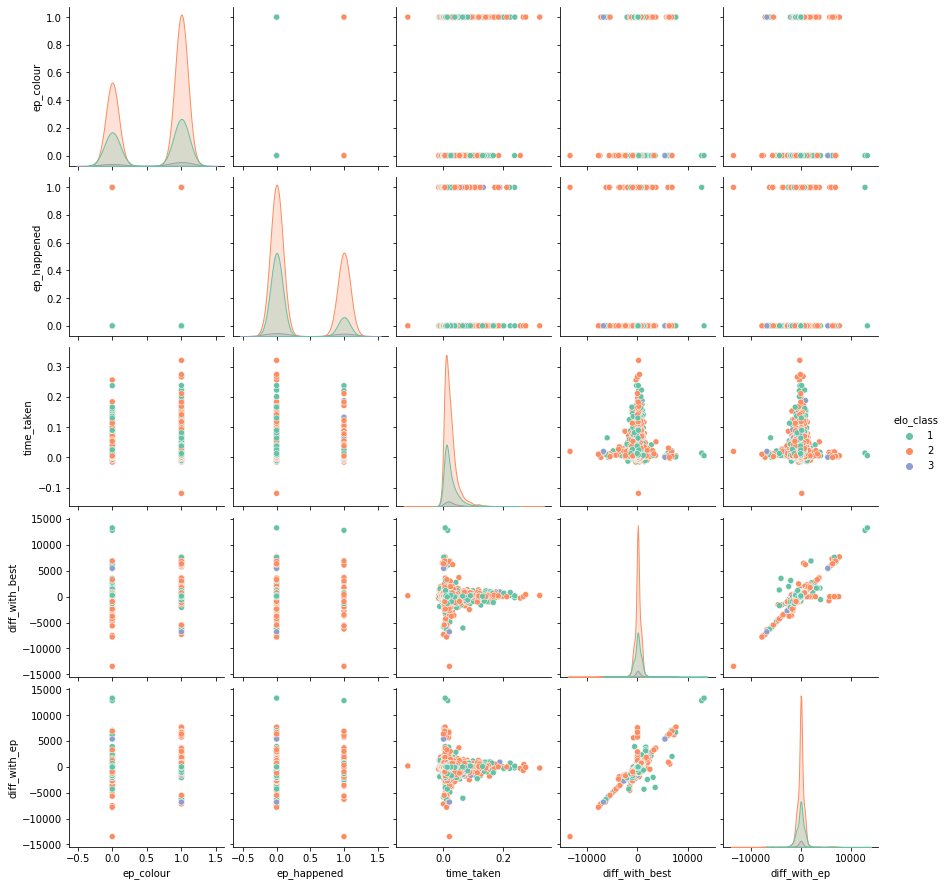

In [11]:
# THIS PART IS COPIED AND PASTED FROM WEEK 8 PCA SOLUTIONS:
# def sort_eigenvalues(eigenvalues, eigenvectors):
#     idx = eigenvalues.argsort()[::-1]   
#     eigenvalues = eigenvalues[idx]
#     eigenvectors = eigenvectors[:,idx]
#     return eigenvalues, eigenvectors

# # THE REST IS HEAVILY INFLUENCED BY WEEK 8 PCA SOLUTIONS

# # Standardise chess_data_without_elo so that it follows the Standard normal distribution
# for col in chess_data_without_elo.columns:
#     chess_data_without_elo[col] = (chess_data_without_elo[col] - chess_data_without_elo[col].mean()) / chess_data_without_elo[col].std()

# # Create matrix storing covariances of the chess dataframe features
# covariances = np.cov(chess_data_without_elo.values.T)

# # Record eigenvalues and eigenvectors
# eigenvalues, eigenvectors = np.linalg.eig(covariances)
# eigenvalues, eigenvalues = sort_eigenvalues(eigenvalues, eigenvectors)

# result = chess_data_without_elo.dot(eigenvectors[:,:2])

# sns.scatterplot(x= result[0], y = result[1], hue=diagnosis)
# plt.xlabel('PC1')
# plt.ylabel('PC2')

def standardize(df):
    standardized = pd.DataFrame()
    for col in df.columns: # We can apply mathematical operation to entire columns at once, as they are built on top of numpy arrays
        standardized[col] = (df[col]-df[col].mean())/df[col].std() #For each column move the data s.t. it is centered around 0 and has variance=1
    return standardized


sns.pairplot(hue='elo_class', data=chess_data_with_elo, palette="Set2")

# # Lila Can we instead use this? :
# standardise = stan
# pca = PCA(n_components=5).fit(chess_data_without_elo.values)
# pca_result = pca.transform(chess_data_without_elo.values)
# sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=)
# plt.xlabel('PC1')
# plt.ylabel('PC2')

[0.41198183 0.22158289 0.1782833  0.16654532 0.02160666]
[[ 0.21398827  1.27270493  0.3890538   1.31906485  0.10117111]
 [ 0.55799894  0.07882179 -0.8172008   1.21107296  0.08057283]
 [-0.84309803 -0.35825124 -1.36685039 -0.46419609 -0.65983516]
 ...
 [ 1.2949376  -1.11879088  1.04369939  0.84640528 -0.10530869]
 [-0.33672617 -0.1402894  -1.11732382 -0.65680348  0.02486967]
 [-0.3252353  -1.43491162  0.64699735 -0.72978152 -0.12977491]]
0.5698711595639246


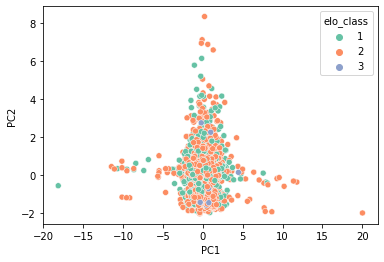

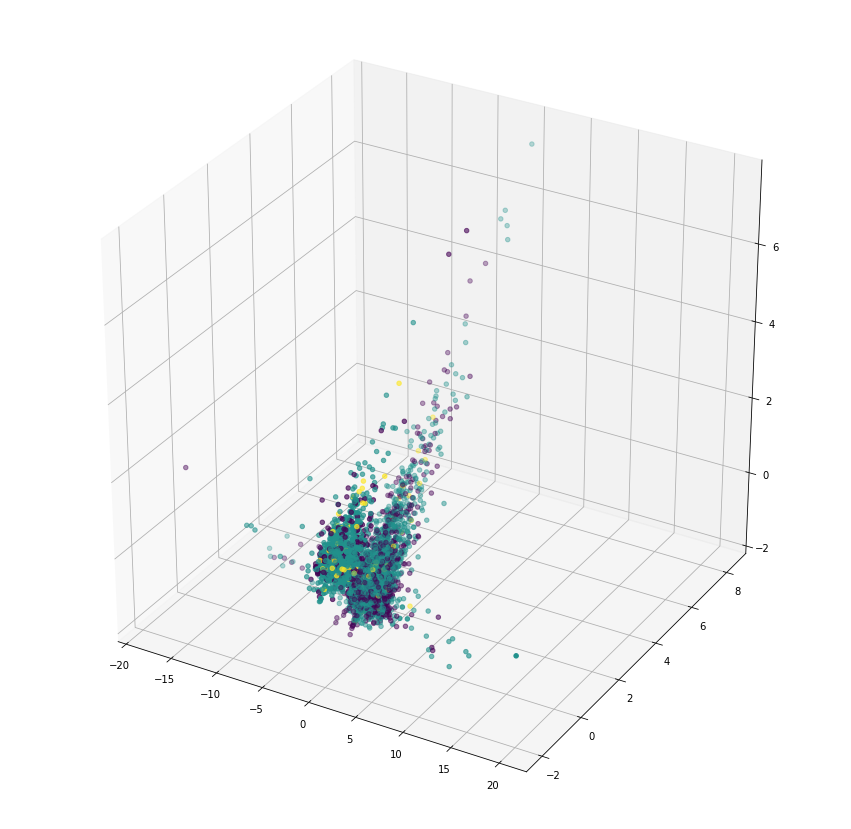

In [67]:
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
elo_labels=chess_data_with_elo["elo_class"]
elo_features=chess_data_with_elo.drop(columns=["elo_class"])

train, test, train_lbl, test_lbl = train_test_split(elo_features, elo_labels, test_size=0.2)

scaler = StandardScaler()
scaler.fit(train)

# Apply transform to both the training set and the test set
# train = standardize(train)
# test = standardize(test)
train = scaler.transform(train)
test = scaler.transform(test)
# Make an instance of the pca model
pca = PCA(n_components=5)
pca.fit(train)
print(pca.explained_variance_ratio_)

# Transform images with pca model
train_result = pca.transform(train)
test_result = pca.transform(test)
print(train_result)
# Make an instance of knn model
knn = KNeighborsClassifier(3)
knn.fit(train_result, train_lbl)

# Accuracy of knn test
accuracy = knn.score(test, test_lbl)
print(accuracy)

sns.scatterplot(x=train_result[:, 0], y=train_result[:, 1], hue=train_lbl, palette="Set2")
plt.xlabel('PC1')
plt.ylabel('PC2')


fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_result[:, 0], train_result[:, 1], train_result[:, 2], c=train_lbl)

# test.drop("time_class")
# print(train.dtypes)
# print()
# print(test.dtypes)

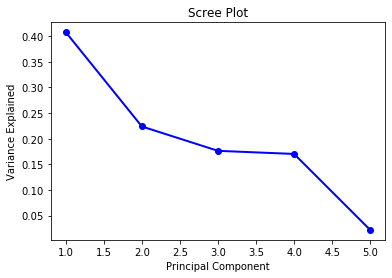

In [19]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [68]:
# calculate min, max and limits
h = .02

x_min, x_max = train_result[:, 0].min() - 1, train_result[:, 0].max() + 1
y_min, y_max = train_result[:, 1].min() - 1, train_result[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
np.arange(y_min, y_max, h))

# predict class using data and kNN classifier
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(train_result[:, 0], train_result[:, 1], c=y, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i)" % (n_neighbors))
plt.show()


ValueError: X has 2 features, but KNeighborsClassifier is expecting 5 features as input.